<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S9/S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
import numpy as np

import torchvision.transforms as transforms

from albumentations.pytorch.transforms import ToTensor
from albumentations.augmentations.transforms import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma,
    Normalize,
    Rotate
)

from albumentations import (
    Compose,
    HueSaturationValue
)

def TransformationFactory(t_type ="pytorch"): 
  
    """Factory Method"""
    transformations = { 
        "albumentations": AlbumentationTransformation, 
        "pytorch": PytorchTransformation,
    } 
  
    return transformations[t_type]()

class AlbumentationTransformation(object):
  def __init__(self):
    super(AlbumentationTransformation, self).__init__()

  def load(self, is_train=False):
    # Mean and standard deviation of train dataset
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    transforms_list = []

    # Use data aug only for train data
    if is_train:
      transforms_list.extend([
        HorizontalFlip(p=0.5)
        ])
    transforms_list.extend([
      Normalize(
        mean=mean,
        std=std,
        max_pixel_value=255.0,
        p=1.0
      ),
      ToTensor()
    ])
    transforms = Compose(transforms_list, p=1.0)
    return lambda img:transforms(image=np.array(img))["image"]

class PytorchTransformation(object):
  def __init__(self):
    super(PytorchTransformation, self).__init__()

  def load(self, is_train=False):
    # Mean and standard deviation of train dataset
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    transforms_list = []

    # Use data aug only for train data
    if is_train:
      transforms_list.extend([
        transforms.RandomHorizontalFlip()
        ])

    transforms_list.extend([
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    return transforms.Compose(transforms_list)

In [49]:
class ImageData(object):

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

  def __init__(self):
    super(ImageData, self).__init__()

  def load(self, transformation_type="pytorch"):
   # Choose from "albumentations" or "pytorch". Default is "pytorch"
   t = TransformationFactory(transformation_type)
   train_transform = t.load(is_train=True)
   test_transform = t.load(is_train=False)

   SEED = 1

   # CUDA?
   cuda = torch.cuda.is_available()
   print("CUDA Available?", cuda)

   # For reproducibility
   torch.manual_seed(SEED)

   if cuda:
     torch.cuda.manual_seed(SEED)

   # dataloader arguments - something you'll fetch these from cmdprmt
   dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

   trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

   testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)

   self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
   self.testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

# Loading data and transforming it
img_data = ImageData()

# Choose from "albumentations" or "pytorch". Default is "pytorch"
img_data.load("albumentations")

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


## Network

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

## Model

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Training and Testing

Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions


In [0]:
import torch
from torch.nn import functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np

class GradCam(object):

  def __init__(self, model, target_layers, num_classes):
    super(GradCam, self).__init__()
    self.model = model
    self.target_layers = target_layers
    self.num_classes = num_classes
    self.device = next(model.parameters()).device

    self.activations_map = {}
    self.gradients_map = {}

    self.model.eval()
    self.register_hooks()

  def register_hooks(self):
    def _wrap_forward_hook(layer_name):
      def _forward_hook(module, input, output):
        self.activations_map[layer_name] = output.detach()
      return _forward_hook

    def _wrap_backward_hook(layer_name):
      def _backward_hook(module, grad_out, grad_in):
        self.gradients_map[layer_name] = grad_out[0].detach()
      return _backward_hook

    for name, module in self.model.named_modules():
      if name in self.target_layers:
        module.register_forward_hook(_wrap_forward_hook(name))
        module.register_backward_hook(_wrap_backward_hook(name))

  def make_one_hots(self, target_class=None):
    one_hots = torch.zeros_like(self.output)
    if target_class:
      ids = torch.LongTensor([[target_class]] * self.batch_size).to(self.device)
      one_hots.scatter_(1,ids,1.0)
    else:
      one_hots = torch.zeros((self.batch_size, self.num_classes)).to(self.device)
      for i in range(len(self.pred)):
        one_hots[i][self.pred[i][0]] = 1.0
    return one_hots

  def forward(self, data):
    self.batch_size, self.img_ch, self.img_h, self.img_w = data.shape
    data = data.to(self.device)
    self.output = self.model(data)
    self.pred = self.output.argmax(dim=1, keepdim=True)

  def backward(self, target_class=None):
    one_hots = self.make_one_hots(target_class)
    self.model.zero_grad()
    self.output.backward(gradient=one_hots, retain_graph=True)

  def __call__(self, data, target_layers, target_class=None):
    self.forward(data)
    self.backward(target_class)

    output = self.output
    saliency_maps = {}
    for target_layer in target_layers:
      activations = self.activations_map[target_layer]  #[64, 512, 4, 4]
      grads = self.gradients_map[target_layer]  #[64, 512, 4, 4]
      weights = F.adaptive_avg_pool2d(grads, 1) #[64, 512, 1, 1]

      saliency_map = torch.mul(activations, weights).sum(dim=1, keepdim=True) 
      saliency_map = F.relu(saliency_map) #[64,1,4,4]
      saliency_map = F.interpolate(saliency_map, (self.img_h, self.img_w),
        mode="bilinear", align_corners=False) #[64,1,32,32]

      saliency_map = saliency_map.view(self.batch_size, -1)
      saliency_map -= saliency_map.min(dim=1, keepdim=True)[0]
      saliency_map /= saliency_map.max(dim=1, keepdim=True)[0]
      saliency_map = saliency_map.view(self.batch_size, 1,
                      self.img_h, self.img_w)
      saliency_maps[target_layer] = saliency_map

    return saliency_maps, self.pred

class VisualizeCam(object):

  def __init__(self, model, classes, target_layers):
    super(VisualizeCam, self).__init__()
    self.model = model
    self.classes = classes
    self.target_layers = target_layers
    self.device = next(model.parameters()).device

    self.gcam = GradCam(model, target_layers, len(classes))
    
  def visualize_cam(self, mask, img):
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
      
    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()
    return heatmap, result

  def plot_heatmaps(self, img_data, target_class, act_class, img_name):
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
      subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle('GradCam at different conv layers for the class: %s which is predicted as %s' % 
      (act_class, target_class), fontsize=13, weight='medium', y=1.05)

    for ax, data in zip(axs.flat, img_data):
      img = data["img"]
      npimg = img.cpu().numpy()
      ax.imshow(np.transpose(npimg, (1, 2, 0)))
      ax.set_title("%s" % (data["label"]))

    plt.savefig(img_name)

  def denormalize(self, tensor, mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010]):
    single_img = False
    if tensor.ndimension() == 3:
      single_img = True
      tensor = tensor[None,:,:,:]

    if not tensor.ndimension() == 4:
      raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    ret = tensor.mul(std).add(mean)
    return ret[0] if single_img else ret

  def __call__(self, images, images_gradcam, target_layers, target_inds=None, metric=""):
    masks_map, pred = self.gcam(images, target_layers, target_inds)
    for i in range(min(len(images),5)):
      grad_img = images_gradcam[i]
      img = images[i]
      results_data = [{
        "img": self.denormalize(img),
        "label": "Result:"
      }]
      heatmaps_data = [{
        "img": self.denormalize(img),
        "label": "Heatmap:"
      }]
      for layer in target_layers:
        mask = masks_map[layer][i]
        heatmap, result = self.visualize_cam(mask, img)
        results_data.append({
          "img": result,
          "label": layer
        })
        heatmaps_data.append({
          "img": heatmap,
          "label": layer
        })
      pred_class = self.classes[grad_img[1].data]
      act_class = self.classes[grad_img[2].data]
      fname = "gradcam_%s_%s_%s.png" % (metric, i, pred_class)
      self.plot_heatmaps(results_data+heatmaps_data, pred_class, act_class, fname)

In [0]:
from tqdm import tqdm
import torch.optim as optim

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class DataModel(object):
  def __init__(self, num_of_epochs = 10, cal_misclassified = False):
    super(DataModel, self).__init__()
    self.train_losses = []
    self.train_acc = []
    self.test_losses = []
    self.test_acc = []
    self.misclassified = []
    self.cal_misclassified = cal_misclassified
    self.EPOCHS = num_of_epochs
    self.can_exit = False
    self.model = None

  def train(self, device, train_loader, optimizer, epoch):
    self.model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = self.model(data)

      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(y_pred, target)
      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)

  def test(self, device, test_loader):
      self.model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = self.model(data)

              loss_function = nn.CrossEntropyLoss()
              loss = loss_function(output, target)

              test_loss += loss.item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              if self.cal_misclassified == True:
                for i in range(len(pred)):
                    if pred[i] != target[i] and len(self.misclassified) < 25:
                        self.misclassified.append([data[i], pred[i], target[i]])
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      accuracy = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset), accuracy))
      
      self.test_acc.append(accuracy)
      if accuracy > 87:
        self.can_exit = True
      
  def run_model(self, net_model):
    self.model = net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

    for epoch in range(self.EPOCHS):
        if self.can_exit:
          print("****Required Accuracy is acheived****")
          break
        print("EPOCH:", epoch + 1)
        self.misclassified = []
        self.train(device, img_data.trainloader, optimizer, epoch)
        self.test(device, img_data.testloader)

  def plot_matrix(self, matrix_data, matrix):
      fig = plt.figure(figsize=(10, 10))
      
      plt.title(matrix)
      plt.xlabel('Epoch')
      plt.ylabel(matrix)

      plt_tuple = ()
      legend_tuple = ()
  
      plt_tuple = plt_tuple + (plt.plot(matrix_data)[0], )
      legend_tuple = legend_tuple

      plt.legend(plt_tuple, legend_tuple)

      fig.savefig(f'val_%s_change.png' % (matrix.lower()))

  def plot_misclassified(self):
    fig = plt.figure(figsize = (10,10))

    for i in range(len(self.misclassified)):
        sub = fig.add_subplot(5, 5, i+1)
        misclassified_transpose = np.transpose(self.misclassified[i][0].cpu().numpy(), (1, 2, 0))
        plt.imshow(misclassified_transpose.squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(img_data.classes[self.misclassified[i][1].data]),str(img_data.classes[self.misclassified[i][2].data])))
        
    plt.tight_layout()

    plt.show()

  def plot_loss_graph(self):
    self.plot_matrix(self.test_losses, "Loss Graph")

  def plot_accuracy_graph(self):
    self.plot_matrix(self.test_acc, "Validation Accuracy")
  
  def plot_GRADcam(self):
    target_layers = ["layer1","layer2","layer3","layer4"]
    viz_cam = VisualizeCam(self.model, img_data.classes, target_layers)

    num_img = 5
    incorrect_pred_imgs = []
    image_for_gradcam = []
    for i in range(num_img):
      incorrect_pred_imgs.append(torch.as_tensor(dm.misclassified[i][0]))
      image_for_gradcam.append(dm.misclassified[i])
    viz_cam(torch.stack(incorrect_pred_imgs), image_for_gradcam, target_layers, metric="incorrect")

## Run the Model

In [48]:
# training the dataset and then running test
dm = DataModel(num_of_epochs = 1, cal_misclassified = True)
dm.run_model(ResNet18())

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=2.494969606399536 Batch_id=390 Accuracy=8.81: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]



Test set: Average loss: 0.0244, Accuracy: 871/10000 (8.71%)



## Plotting Validation Accuracy

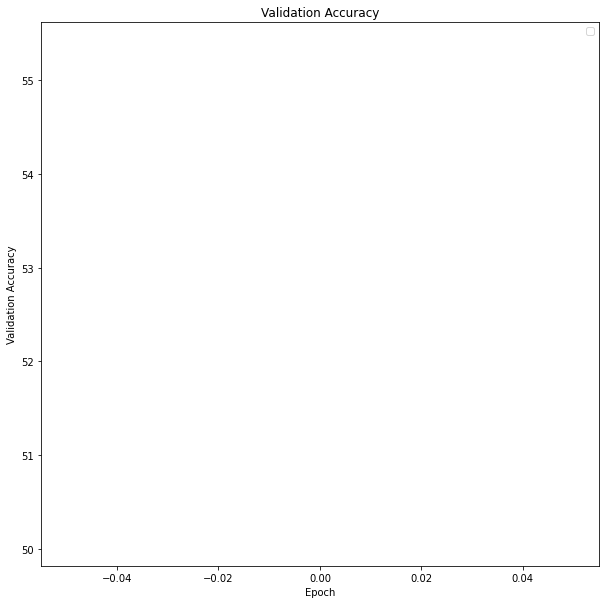

In [9]:
dm.plot_accuracy_graph()

## Plotting Loss Graph

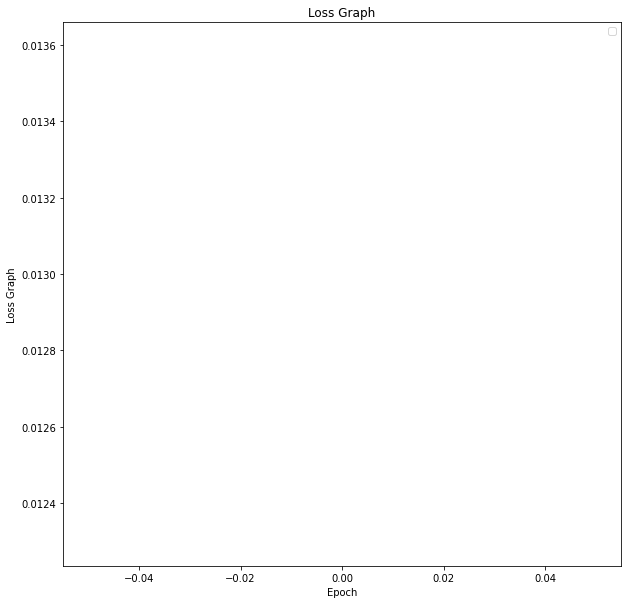

In [10]:
dm.plot_loss_graph()

## Plotting Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

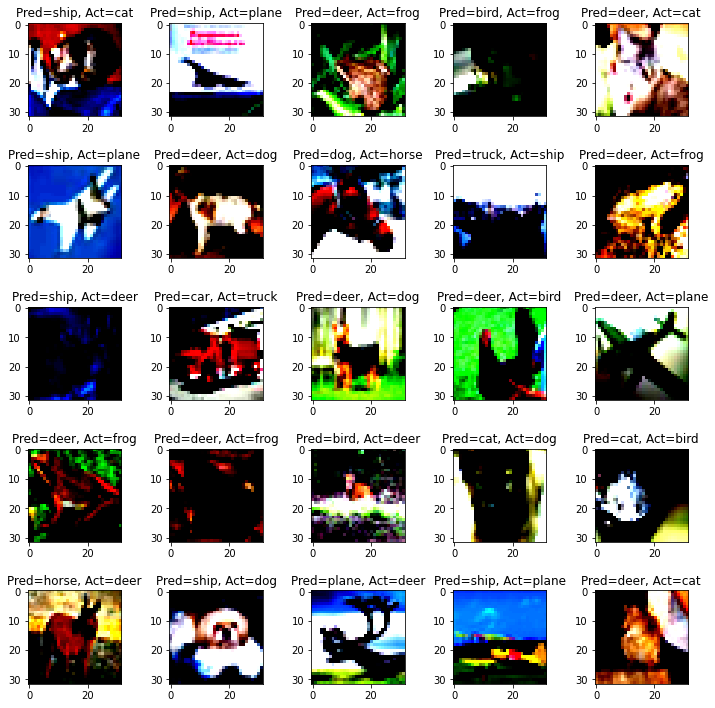

In [11]:
dm.plot_misclassified()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

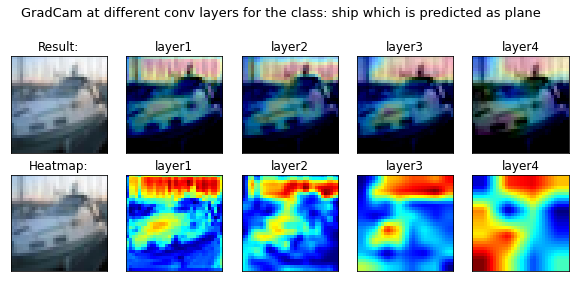

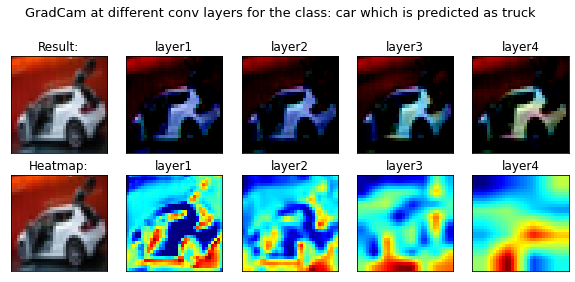

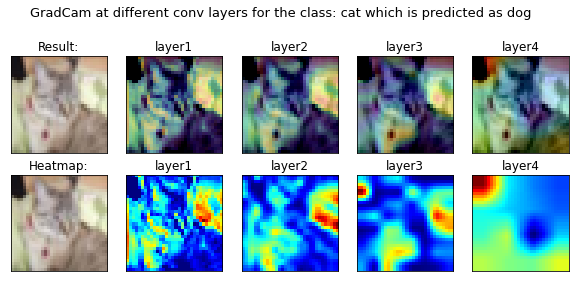

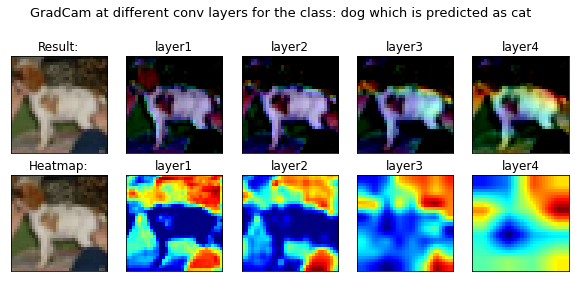

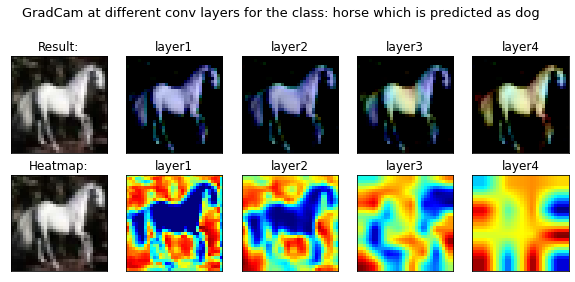

In [44]:
dm.plot_GRADcam()